# Training a model

Below is the example for a Gaussian Process regression using GpyTorch :class:`.ExactGaussianProcessRegressor`

This example shows how to use a AdditiveGridInducingVariationalGP module. This classifcation module is designed for when the function you’re modeling has an additive decomposition over dimension (if it doesn't you should use GridInterpolationKernel).

In [1]:
# import gpytorch and gpwrapper in a directory above
import sys
sys.path.append("..")

import math
import torch
import gpytorch
import numpy
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, AdditiveGridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from gpwrapper import ExactGaussianProcessRegressor

# Inline plotting
%matplotlib inline

In [2]:
# We store the data as a 10k 1D vector
# It actually represents [0,1]x[0,1] in cartesian coordinates
n = 100
train_x = torch.zeros(pow(n, 2), 2)
for i in range(n):
    for j in range(n):
        # Each coordinate varies from 0 to 1 in n=100 steps
        train_x[i * n + j][0] = float(i) / (n-1)
        train_x[i * n + j][1] = float(j) / (n-1)
# Cuda variable the x_data
train_x = Variable(train_x) # .cuda()
# function is y=sin(x0) + 2*pi*cos(x1)
train_y = Variable((torch.sin(train_x.data[:, 0]) + torch.cos(train_x.data[:, 1])) * (2 * math.pi)) #.cuda()

In [8]:
# Step 1: Define the GP model
# Use the exact GP model for regression and interpolate between grid points
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        # Constant mean and RBF kernel
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        # Put the AdditiveGridInterpolationKernel over the RBF kernel
        # There are two dimensions (n_components=2)
        self.covar_module = AdditiveGridInterpolationKernel(self.base_covar_module,
                                                            grid_size=400,
                                                            grid_bounds=[(-2, 2)],
                                                            n_components=2)
        # Register the lengthscale of the RBF kernel as a parameter to be optimized
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])),
                                bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        # Put the input through the AdditiveGridInterpolationKernel and scale
        # the covariance matrix
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

In [4]:
# Step 2: Wrap the model into our GP Wrapper
GP = ExactGaussianProcessRegressor(
    module = GPRegressionModel,
    train_split = None,
    max_epochs = 20,
)

# Step 3: Find optimal model hyperparameters
GP.fit(X=train_x, y=train_y)

# Step 4: Prediction
# Create 100 test data points
# Over the square [0,1]x[0,1]
n = 10
test_x = Variable(torch.zeros(int(pow(n, 2)), 2)) #.cuda()
for i in range(n):
    for j in range(n):
        test_x.data[i * n + j][0] = float(i) / (n-1)
        test_x.data[i * n + j][1] = float(j) / (n-1)
        
observed_pred = GP.predict_proba(X=test_x)

  epoch    train_loss     dur
-------  ------------  ------
      1       -1.5704  1.3976
      2       -1.6211  1.1012
      3       -1.6712  1.1686
      4       -1.7214  1.1101
      5       -1.7721  1.1082
      6       -1.8224  1.4015
      7       -1.8724  1.5305
      8       -1.9228  1.2513
      9       -1.9732  1.8939
     10       -2.0219  1.1800
     11       -2.0721  1.5800
     12       -2.1228  1.3416
     13       -2.1726  1.2830
     14       -2.2225  1.5387
     15       -2.2728  1.2599
     16       -2.3229  1.6961
     17       -2.3737  1.2455
     18       -2.4229  1.4994
     19       -2.4732  1.1646
     20       -2.5228  1.1163


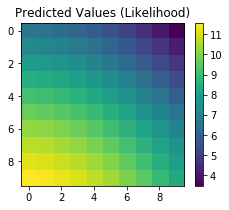

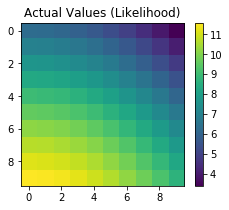

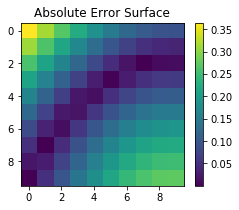

In [5]:
# the mean of the Gaussians are our predicted labels
pred_labels = observed_pred.mean().view(n, n).data.cpu().numpy()

# Calculate the true test values
test_y_actual = ((torch.sin(test_x.data[:, 0]) + torch.cos(test_x.data[:, 1])) * (2 * math.pi))
test_y_actual = test_y_actual.cpu().numpy().reshape(n, n)
# Compute absolute error
delta_y = numpy.absolute(pred_labels - test_y_actual)

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Make a plot of the predicted values
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax, pred_labels, 'Predicted Values (Likelihood)')
# Make a plot of the actual values
f, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')
# Make a plot of the errors
f, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(f, observed_ax3, delta_y, 'Absolute Error Surface')

# Using Sklearn Pipeline
Same as skorch, our wrapper provides an sklearn-compatible interface, so it is possible to put it into an sklearn Pipeline. An example is shown below:

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

GP = ExactGaussianProcessRegressor(
    module = GPRegressionModel,
    train_split = None,
    max_epochs = 20,
)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('GP', GP),
])

pipe.fit(X=train_x, y=train_y) # modify grid bound to (-2,2) to get it work

  epoch    train_loss     dur
-------  ------------  ------
      1       -1.5675  2.4358
      2       -1.6157  1.4487
      3       -1.6652  2.0298
      4       -1.7172  1.5854
      5       -1.7665  1.4812
      6       -1.8177  1.5975
      7       -1.8686  1.5361
      8       -1.9191  1.6141
      9       -1.9705  1.7959
     10       -2.0196  1.4611
     11       -2.0700  1.5372
     12       -2.1207  1.6713
     13       -2.1700  1.8178
     14       -2.2202  1.8555
     15       -2.2715  1.5756
     16       -2.3208  2.0216
     17       -2.3699  1.3392
     18       -2.4211  1.3765
     19       -2.4711  1.9889
     20       -2.5218  1.4561


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('GP', <class 'gpwrapper.ExactGaussianProcessRegressor'>[initialized](
  module_=GPRegressionModel(
    (likelihood): GaussianLikelihood()
    (mean_module): ConstantMean()
    (base_covar_module): RBFKernel()
    (covar_module): AdditiveGridInterpolationKernel(
      (base_kernel_module): RBFKernel()
    )
  ),
))])

# Grid search
Same as skorch, another advantage of our wrapper is that you can perform an sklearn GridSearchCV or RandomizedSearchCV in Gpytorch to find optimal hyperparameters. Here is an example:

In [7]:
from sklearn.model_selection import GridSearchCV

params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
}

GP = ExactGaussianProcessRegressor(
    module = GPRegressionModel,
    train_split = None,
    max_epochs = 20,
)

gs = GridSearchCV(GP, params, refit=False, cv=3, scoring='r2',
                 return_train_score=False)  # Use a different scoring function maybe?

gs.fit(X=train_x, y=train_y)
print('\n gs.best_score_ = {}, gs.best_params = {}'.format(gs.best_score_, gs.best_params_))

  epoch    train_loss     dur
-------  ------------  ------
      1       -1.5672  1.1809
      2       -1.5722  1.2599
      3       -1.5774  1.0079
      4       -1.5822  0.9735
      5       -1.5875  1.6496
      6       -1.5928  1.1853
      7       -1.5972  1.0220
      8       -1.6025  0.9726
      9       -1.6070  0.9773
     10       -1.6130  1.1215
  epoch    train_loss     dur
-------  ------------  ------
      1       -1.5661  0.9878
      2       -1.5712  0.9357
      3       -1.5763  1.0275
      4       -1.5815  0.8438
      5       -1.5869  0.7440
      6       -1.5909  0.7679
      7       -1.5973  0.7551
      8       -1.6013  0.8880
      9       -1.6070  1.2223
     10       -1.6117  0.9469
  epoch    train_loss     dur
-------  ------------  ------
      1       -1.5669  0.9061
      2       -1.5720  0.9040
      3       -1.5766  0.8196
      4       -1.5817  0.7394
      5       -1.5873  0.8920
      6       -1.5929  1.4350
      7       -1.5971  0.8790
      8   

### Note:
Need to comment out **line 157 - 161** of `.../anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/utils/__init__.py`
```
if hasattr(X, 'take') and (hasattr(indices, 'dtype') and
                           indices.dtype.kind == 'i'):
    # This is often substantially faster than X[indices]
    return X.take(indices, axis=0)
else:
```
Otherwise an error would occur saying
`argument 'index' (position 1) must be Tensor, not numpy.ndarray`